## General

This notebook will generate text embeddings on the product titles.

Product titles will havev stop words removed and tokenized using a regex tokenizer.

TF-IDF vectorizer or Google Language-agnostic BERT Sentence Embedding will be used to generate the embeddings.

Text embeddings will be used to predict nearest neighbours using the sklearn.NearestNeighbors algorithm.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import scipy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

In [2]:
# Load train data with matches and image duplicates
train = pd.DataFrame(np.load('../datasets/train.npy', allow_pickle=True),
                     columns=['posting_id', 'image', 'image_phash', 'title', 'label_group', 'matches', 'image_duplicates'])

In [3]:
# Create function to make predictions of closest neighbours based on embeddings and distance cutoff
def predict(df, embeddings, n_neighbours, threshold, metric = 'euclidean'):
    preds = []
    
    # Generate distances and indices of each data point using sklearn NearestNeighbors
    NN_model = NearestNeighbors(n_neighbors = n_neighbours, n_jobs=-1, metric = metric)
    NN_model.fit(embeddings)
    distances, indices = NN_model.kneighbors(embeddings)

    # Append posting_ids of indices that are within distance threshold
    for i in range(embeddings.shape[0]):
        idx = indices[i][np.where(distances[i] <= threshold)]
        posting_ids = df['posting_id'].iloc[idx].values
        preds.append(posting_ids)
  
    return preds

In [4]:
# Create function to generate F1 score for each row of predictions and actual matches
def scores(matches, preds):
    result = []
    for i in range(len(matches)):
        n = len(np.intersect1d(matches[i], preds[i]))
        score = 2*n / (len(matches[i]) + len(preds[i]))
        result.append(score)
    return result

In [5]:
# Create function to grid search over various distance thresholds
def distance_search(df, embeddings, n_neighbours, thresholds = list(range(21)), metric = 'euclidean'):
    matches = list(df['matches'].to_numpy())
    for t in thresholds:
        predictions_t = predict(df, embeddings, n_neighbours, t, metric)
        f1_score_t = scores(matches, predictions_t)
        print(f'At threshold {t}, average F1 score is {np.mean(f1_score_t)}')

In [6]:
# Obtain the actual matches
matches = list(train['matches'].to_numpy())

In [7]:
# Create function for generating tokens from titles
def process_tokens(title, stop_words, tokenizer):
    words = tokenizer.tokenize(title.lower())
    return ' '.join([word for word in words if word not in stop_words])

## Stop Words

In [8]:
# Potential stop words:
shopee_words = [# Sales words:
                'free', 'gift', 'give', 'get', 'ready', 'stock', 'stocks', 'stok',
                'ori', 'original', 'official', 'new', 'latest',
                'import', 'low', 'price', 'cheap', 'vip', 'discount', 'warranty',
                'promo', 'promotion', 'buy', 'buyer', 'shop', 'shopper', 'shopping',
                'bigsale', 'sale', 'sell', 'seller', 'resell', 'reseller',
                'all', 'any', 'full', 'include', 'includes', 'inclusive', 'tax',
    
                # Units
                'pieces', 'piece', 'pcs', 'pc', 'box', 'boxes', 'pack', 'packs', 'packet', 'packets', 'paket', 'package',
                'set', 'sets', 'size', 'roll', 'rolls', 'sachet', 'sachets'
                
                # Dimensions
                'ml', 'l', 'litre', 'liter', 'g', 'gr', 'gram', 'kg', 'kilo', 'kilogram',
                'mm', 'cm', 'm', 'meter', 'metre', 'yard', 'inch', 'x',
    
                # Miscellaneous alphabets
                'c', 'xe', 'f', 'b', 'v', 'xa',
                
                # Location words:
                'shopee', 'indonesia', 'indonesian', 'indo', 'id', 'jakarta', 'local', 'lokal',
    
                # English descriptors:
                'fashion', 'colour', 'color', 'design',
                'plus', 'pro', 'mini', 'premium', 'pro', 'super', 'extra', 'big', 'small',
                
                # Indonesian descriptors:
                'bpom', 'muat', 'cod', 'murah', 'isi', 'warna', 'pajak', 'garansi', 'beli', 'gratis',
                'terbaru', 'harga', 'resmi',
                
]

# Add NLTK English and Indonesian stop words
stop_words = stopwords.words('english') + \
             stopwords.words('indonesian') + \
             shopee_words

stop_words = list(set(stop_words))

## Predict Nearest Neighbours

### All stop words, '[a-zA-Z]+', TF-IDF Vectorizer

In [9]:
tokenizer = nltk.tokenize.RegexpTokenizer('[a-zA-Z]+')

In [10]:
train['tokens_0'] = train['title'].map(lambda x: process_tokens(x, stop_words, tokenizer))

In [11]:
tvec = TfidfVectorizer()

In [12]:
text_embeddings = tvec.fit_transform(train['tokens_0'])

In [13]:
# Search various Euclidean distance thresholds
distance_search(train, text_embeddings, 51, thresholds = [i/10 for i in range(5,11)])

At threshold 0.5, average F1 score is 0.5557532623162812
At threshold 0.6, average F1 score is 0.580493931594206
At threshold 0.7, average F1 score is 0.6083460635896855
At threshold 0.8, average F1 score is 0.6284641141987889
At threshold 0.9, average F1 score is 0.6319504213134385
At threshold 1.0, average F1 score is 0.39984188221545025


In [14]:
# Search various cosine distance thresholds
distance_search(train, text_embeddings, 51, np.linspace(0.2,0.5,10), 'cosine')

At threshold 0.2, average F1 score is 0.5894334201351014
At threshold 0.23333333333333334, average F1 score is 0.6042942032486653
At threshold 0.26666666666666666, average F1 score is 0.6146645587951023
At threshold 0.30000000000000004, average F1 score is 0.6239744478533359
At threshold 0.33333333333333337, average F1 score is 0.6309498404046342
At threshold 0.3666666666666667, average F1 score is 0.6338100222608829
At threshold 0.4, average F1 score is 0.632695255293247
At threshold 0.43333333333333335, average F1 score is 0.6260693467987836
At threshold 0.4666666666666667, average F1 score is 0.6145501669708143
At threshold 0.5, average F1 score is 0.5957103069589159


### No stop words, '[a-zA-Z]+', TF-IDF Vectorizer

In [15]:
train['tokens_1'] = train['title'].map(lambda x: process_tokens(x, [], tokenizer))

In [16]:
tvec_1 = TfidfVectorizer()

In [17]:
text_embeddings_1 = tvec_1.fit_transform(train['tokens_1'])

In [18]:
# Search various Euclidean distance thresholds
distance_search(train, text_embeddings_1, 51, thresholds = [i/10 for i in range(5,11)])

At threshold 0.5, average F1 score is 0.5476025991430348
At threshold 0.6, average F1 score is 0.5733747642424502
At threshold 0.7, average F1 score is 0.6020336283142788
At threshold 0.8, average F1 score is 0.6271314095641021
At threshold 0.9, average F1 score is 0.6369325568809813
At threshold 1.0, average F1 score is 0.6104419490869555


In [19]:
# Search various cosine distance thresholds
distance_search(train, text_embeddings_1, 51, np.linspace(0.2,0.5,10), 'cosine')

At threshold 0.2, average F1 score is 0.5825867561446958
At threshold 0.23333333333333334, average F1 score is 0.5973848746958439
At threshold 0.26666666666666666, average F1 score is 0.609540526536195
At threshold 0.30000000000000004, average F1 score is 0.6216330494588659
At threshold 0.33333333333333337, average F1 score is 0.6299951334861443
At threshold 0.3666666666666667, average F1 score is 0.635718784538503
At threshold 0.4, average F1 score is 0.6369032561392899
At threshold 0.43333333333333335, average F1 score is 0.6343390018099309
At threshold 0.4666666666666667, average F1 score is 0.6255413967384063
At threshold 0.5, average F1 score is 0.6104451770967562


### All stop words, '[a-zA-Z0-9]+', TF-IDF Vectorizer

In [9]:
tokenizer_1 = nltk.tokenize.RegexpTokenizer('[a-zA-Z0-9]+')

In [10]:
train['tokens_2'] = train['title'].map(lambda x: process_tokens(x, stop_words, tokenizer_1))

In [11]:
tvec_2 = TfidfVectorizer()

In [12]:
text_embeddings_2 = tvec_2.fit_transform(train['tokens_2'])

In [24]:
# Search various Euclidean distance thresholds
distance_search(train, text_embeddings_2, 51, thresholds = [i/10 for i in range(5,11)])

At threshold 0.5, average F1 score is 0.5404591258048662
At threshold 0.6, average F1 score is 0.5675157172002296
At threshold 0.7, average F1 score is 0.5988271005366695
At threshold 0.8, average F1 score is 0.628120749869296
At threshold 0.9, average F1 score is 0.6467069275429707
At threshold 1.0, average F1 score is 0.4119318506542231


In [25]:
# Search various cosine distance thresholds
distance_search(train, text_embeddings_2, 51, np.linspace(0.2,0.5,10), 'cosine')

At threshold 0.2, average F1 score is 0.5774061351182067
At threshold 0.23333333333333334, average F1 score is 0.5931207493654278
At threshold 0.26666666666666666, average F1 score is 0.6079349169126889
At threshold 0.30000000000000004, average F1 score is 0.6215436604936374
At threshold 0.33333333333333337, average F1 score is 0.6325594412702064
At threshold 0.3666666666666667, average F1 score is 0.6404349492888787
At threshold 0.4, average F1 score is 0.6455586193211992
At threshold 0.43333333333333335, average F1 score is 0.6467182485415763
At threshold 0.4666666666666667, average F1 score is 0.640671687624284
At threshold 0.5, average F1 score is 0.628441686251668


### No stop words, '[a-zA-Z0-9]+', TF-IDF Vectorizer

In [13]:
train['tokens_3'] = train['title'].map(lambda x: process_tokens(x, [], tokenizer_1))

In [14]:
tvec_3 = TfidfVectorizer()

In [15]:
text_embeddings_3 = tvec_3.fit_transform(train['tokens_3'])

In [29]:
# Search various Euclidean distance thresholds
distance_search(train, text_embeddings_3, 51, thresholds = [i/10 for i in range(5,11)])

At threshold 0.5, average F1 score is 0.5342647357435617
At threshold 0.6, average F1 score is 0.5609956795899799
At threshold 0.7, average F1 score is 0.5930479783916213
At threshold 0.8, average F1 score is 0.6249583601618918
At threshold 0.9, average F1 score is 0.646036632174972
At threshold 1.0, average F1 score is 0.6376547406971069


In [30]:
# Search various cosine distance thresholds
distance_search(train, text_embeddings_3, 51, np.linspace(0.2,0.5,10), 'cosine')

At threshold 0.2, average F1 score is 0.5709745158102677
At threshold 0.23333333333333334, average F1 score is 0.5867812409486799
At threshold 0.26666666666666666, average F1 score is 0.6025977411890335
At threshold 0.30000000000000004, average F1 score is 0.6173302356977906
At threshold 0.33333333333333337, average F1 score is 0.6293550105128367
At threshold 0.3666666666666667, average F1 score is 0.6392664638703714
At threshold 0.4, average F1 score is 0.6453440493966236
At threshold 0.43333333333333335, average F1 score is 0.6488987883907971
At threshold 0.4666666666666667, average F1 score is 0.6467432242700967
At threshold 0.5, average F1 score is 0.6376541682053365


### Semantic Embedding with Google Language-agnostic BERT sentence embedding (LaBSE)

Using token sets 2 and 3 from above, semantic embeddings were generated using Google [LaBSE](https://tfhub.dev/google/LaBSE/1) in a separate colab notebook.

In [16]:
# Load embeddings from colab notebook 04a_semantic_text_embedding_labse
text_labse_embeddings_2 = np.load('../datasets/text_labse_embeddings_2.npy', allow_pickle=True)
text_labse_embeddings_3 = np.load('../datasets/text_labse_embeddings_3.npy', allow_pickle=True)

In [10]:
# Search various Euclidean distance thresholds
distance_search(train, text_labse_embeddings_2, 51, thresholds = [i/10 for i in range(2,8)])

At threshold 0.2, average F1 score is 0.5023383575289185
At threshold 0.3, average F1 score is 0.5206897488763047
At threshold 0.4, average F1 score is 0.5534296470749562
At threshold 0.5, average F1 score is 0.5888610845699728
At threshold 0.6, average F1 score is 0.6193284833094093
At threshold 0.7, average F1 score is 0.6064169123850193


In [15]:
# Search various cosine distance thresholds
distance_search(train, text_labse_embeddings_2, 51, np.linspace(0,0.3,10), 'cosine')

At threshold 0.0, average F1 score is 0.3524689991453168
At threshold 0.03333333333333333, average F1 score is 0.5112982395068995
At threshold 0.06666666666666667, average F1 score is 0.5407712029044337
At threshold 0.1, average F1 score is 0.570217711516749
At threshold 0.13333333333333333, average F1 score is 0.5954925673945736
At threshold 0.16666666666666666, average F1 score is 0.6145377614410998
At threshold 0.2, average F1 score is 0.622890836875454
At threshold 0.23333333333333334, average F1 score is 0.6147820431254368
At threshold 0.26666666666666666, average F1 score is 0.5843042102108974
At threshold 0.3, average F1 score is 0.5353658651064455


In [11]:
# Search various Euclidean distance thresholds
distance_search(train, text_labse_embeddings_3, 51, thresholds = [i/10 for i in range(2,8)])

At threshold 0.2, average F1 score is 0.4959718413618015
At threshold 0.3, average F1 score is 0.5134388629157827
At threshold 0.4, average F1 score is 0.5456805229695829
At threshold 0.5, average F1 score is 0.5845024093830556
At threshold 0.6, average F1 score is 0.616875363654448
At threshold 0.7, average F1 score is 0.6118850983653447


In [16]:
# Search various cosine distance thresholds
distance_search(train, text_labse_embeddings_3, 51, np.linspace(0,0.3,10), 'cosine')

At threshold 0.0, average F1 score is 0.3475030353844307
At threshold 0.03333333333333333, average F1 score is 0.5046889935151952
At threshold 0.06666666666666667, average F1 score is 0.5333680227991676
At threshold 0.1, average F1 score is 0.5641543500459845
At threshold 0.13333333333333333, average F1 score is 0.5911509637340334
At threshold 0.16666666666666666, average F1 score is 0.611531530948464
At threshold 0.2, average F1 score is 0.6209531269612909
At threshold 0.23333333333333334, average F1 score is 0.6178962372926665
At threshold 0.26666666666666666, average F1 score is 0.5929541711291831
At threshold 0.3, average F1 score is 0.5466488822241434


As a standalone model, using language-agnostic sentence level semantic embeddings on product titles seem to perform worse than embedding using TF-IDF vectorizer.

However, we can try to concatenate the semantic embeddings with the image embeddings and do the nearest neighbours search on the combined embeddings.

### Save Best Results

Best TF-IDF vectorizer embedding models:

- embeddings_2
    - Cosine threshold 0.4333 - score: 0.6467
- embeddings_3
    - Cosine threshold 0.4333 - score: **0.6489**
    
Best LaBSE semantic embedding models:

- labse_embeddings_2
    - Cosine threshold 0.2 - score: 0.6229
- labse_embeddings_3
    - Cosine threshold 0.2 - score: 0.6210

In [17]:
# Save predictions and scores from best TF-IDF text models
text_predictions_2t = predict(train, text_embeddings_2, 51, 0.43333, 'cosine')
text_f1_scores_2t = scores(matches, text_predictions_2t)

text_predictions_3t = predict(train, text_embeddings_3, 51, 0.43333, 'cosine')
text_f1_scores_3t = scores(matches, text_predictions_3t)

In [18]:
train['text_predictions_2t'] = text_predictions_2t
train['text_f1_scores_2t'] = text_f1_scores_2t
train['text_predictions_3t'] = text_predictions_3t
train['text_f1_scores_3t'] = text_f1_scores_3t

In [19]:
# Save predictions and scores from best LaBSE text models
text_predictions_2s = predict(train, text_labse_embeddings_2, 51, 0.2, 'cosine')
text_f1_scores_2s = scores(matches, text_predictions_2s)
text_predictions_3s = predict(train, text_labse_embeddings_3, 51, 0.2, 'cosine')
text_f1_scores_3s = scores(matches, text_predictions_3s)

In [20]:
train['text_predictions_2s'] = text_predictions_2s
train['text_f1_scores_2s'] = text_f1_scores_2s
train['text_predictions_3s'] = text_predictions_3s
train['text_f1_scores_3s'] = text_f1_scores_3s

In [21]:
train[['posting_id', 'image', 'title', 'label_group', 'matches',
       'tokens_2', 'text_predictions_2t', 'text_f1_scores_2t', 'text_predictions_2s', 'text_f1_scores_2s',
       'tokens_3', 'text_predictions_3t', 'text_f1_scores_3t', 'text_predictions_3s', 'text_f1_scores_3s']].head()

posting_id                                 image  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg   

                                               title label_group  \
0                          Paper Bag Victoria Secret   249114794   
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...  2937985045   
2        Maling TTS Canned Pork Luncheon Meat 397 gr  2395904891   
3  Daster Batik Lengan pendek - Motif Acak / Camp...  4093212188   
4                  Nescafe \xc3\x89clair Latte 220ml  3648931069   

                                matches  \
0   [train_129225211, train_2278313361]   
1  [train_3386243561, train_3423213080]   
2  [train_2288590299, train_3803689425]   
3  [train_2406599165, train_3342059966]   
4   [train_3369186413, train_921438619]   

                                            tokens_2  \
0                          paper bag victoria secret   
1         double tape 3m vhb 12 4 5 double foam tape   
2           maling tts canned pork luncheon meat 397   
3  daster batik lengan pendek motif acak campur l...   
4                   nescafe xc3 x89clair latte 220ml   

                                 text_predictions_2t  text_f1_scores_2t  \
0                [train_129225211, train_2278313361]           1.000000   
1  [train_3386243561, train_3423213080, train_197...           0.400000   
2               [train_2288590299, train_3803689425]           1.000000   
3  [train_2406599165, train_1744956981, train_352...           0.200000   
4                                 [train_3369186413]           0.666667   

                                 text_predictions_2s  text_f1_scores_2s  \
0                [train_129225211, train_2278313361]           1.000000   
1  [train_3386243561, train_3423213080, train_197...           0.571429   
2               [train_2288590299, train_3803689425]           1.000000   
3  [train_1744956981, train_2406599165, train_352...           0.285714   
4                [train_3369186413, train_921438619]           1.000000   

                                            tokens_3  \
0                          paper bag victoria secret   
1  double tape 3m vhb 12 mm x 4 5 m original doub...   
2        maling tts canned pork luncheon meat 397 gr   
3  daster batik lengan pendek motif acak campur l...   
4                   nescafe xc3 x89clair latte 220ml   

                                 text_predictions_3t  text_f1_scores_3t  \
0                [train_129225211, train_2278313361]           1.000000   
1  [train_3386243561, train_3423213080, train_197...           0.500000   
2               [train_2288590299, train_3803689425]           1.000000   
3  [train_1744956981, train_2406599165, train_352...           0.222222   
4                                 [train_3369186413]           0.666667   

                                 text_predictions_3s  text_f1_scores_3s  
0                [train_2278313361, train_129225211]           1.000000  
1  [train_3386243561, train_3423213080, train_211...           0.571429  
2               [train_2288590299, train_3803689425]           1.000000  
3  [train_1744956981, train_2406599165, train_352...           0.285714  
4                [train_3369186413, train_921438619]           1.000000

In [22]:
# Save text predictions and F1 scores
np.save('../datasets/train_text_predictions.npy',
        train[['posting_id', 'image', 'title', 'label_group', 'matches',
       'tokens_2', 'text_predictions_2t', 'text_f1_scores_2t', 'text_predictions_2s', 'text_f1_scores_2s',
       'tokens_3', 'text_predictions_3t', 'text_f1_scores_3t', 'text_predictions_3s', 'text_f1_scores_3s']].to_numpy())

In [36]:
# Save distances and indices of best text model 3c
NN_model = NearestNeighbors(n_neighbors = 51, metric = 'cosine')
NN_model.fit(text_embeddings_3)
distances, indices = NN_model.kneighbors(text_embeddings_3)

In [37]:
np.save('../datasets/best_text_distances.npy', distances)
np.save('../datasets/best_text_indices.npy', indices)

In [38]:
# Save embeddings of best text model 3c
scipy.sparse.save_npz('../datasets/train_text_embeddings.npz', text_embeddings_3)

## Scores and Results

|No |Tokens|Embedding Model|Distance Threshold|Average F1 Score|
|---|----- |---------------|------------------|----------------|
|2t  |All stop words, [a-zA-Z0-9]+ regex tokenizer|TF-IDF vectorizer|Cosine 0.433|0.6467|
|2s  |All stop words, [a-zA-Z0-9]+ regex tokenizer|LaBSE|Cosine 0.2|0.6229|
|3t  |No stop words, [a-zA-Z0-9]+ regex tokenizer|TF-IDF vectorizer|Cosine 0.433|**0.6489**|
|3s  |No stop words, [a-zA-Z0-9]+ regex tokenizer|LaBSE|Cosine 0.2|0.6210|

In [23]:
# Load text predictions and F1 scores
train = pd.DataFrame(np.load('../datasets/train_text_predictions.npy', allow_pickle=True),
                     columns=['posting_id', 'image', 'title', 'label_group', 'matches',
                              'tokens_2', 'text_predictions_2t', 'text_f1_scores_2t',
                              'text_predictions_2s', 'text_f1_scores_2s',
                              'tokens_3', 'text_predictions_3t', 'text_f1_scores_3t',
                              'text_predictions_3s', 'text_f1_scores_3s'])

### Distribution of F1 Scores

In [30]:
# Tokens and models to examine
tokens = [2, 2, 3, 3]
models = ['2t', '2s', '3t', '3s']

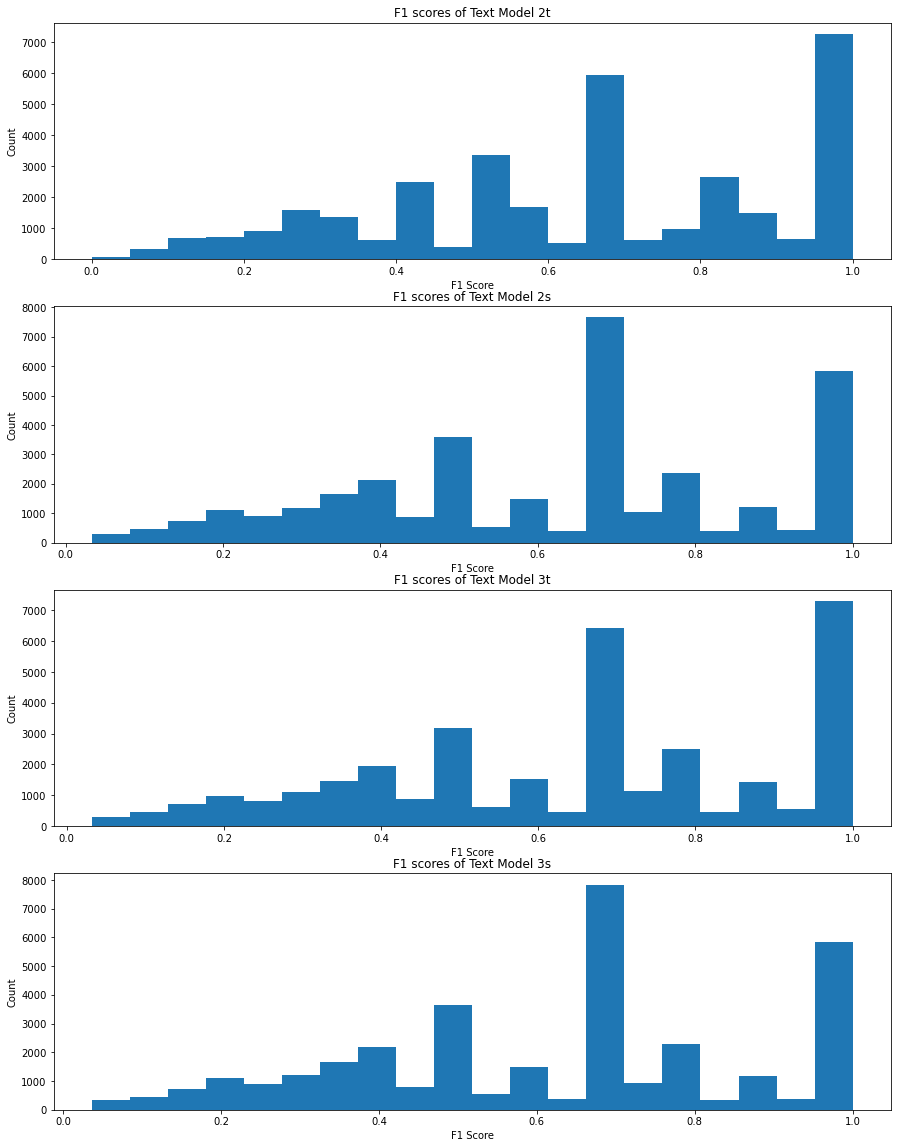

In [31]:
# Check distribution of F1 scores
plt.figure(figsize=(15,5*len(models)))

for i in range(len(models)):
    plt.subplot(len(models), 1, i + 1)
    plt.hist(train[f'text_f1_scores_{models[i]}'], bins=20)
    plt.ylabel('Count')
    plt.xlabel('F1 Score')
    plt.title(f'F1 scores of Text Model {models[i]}')

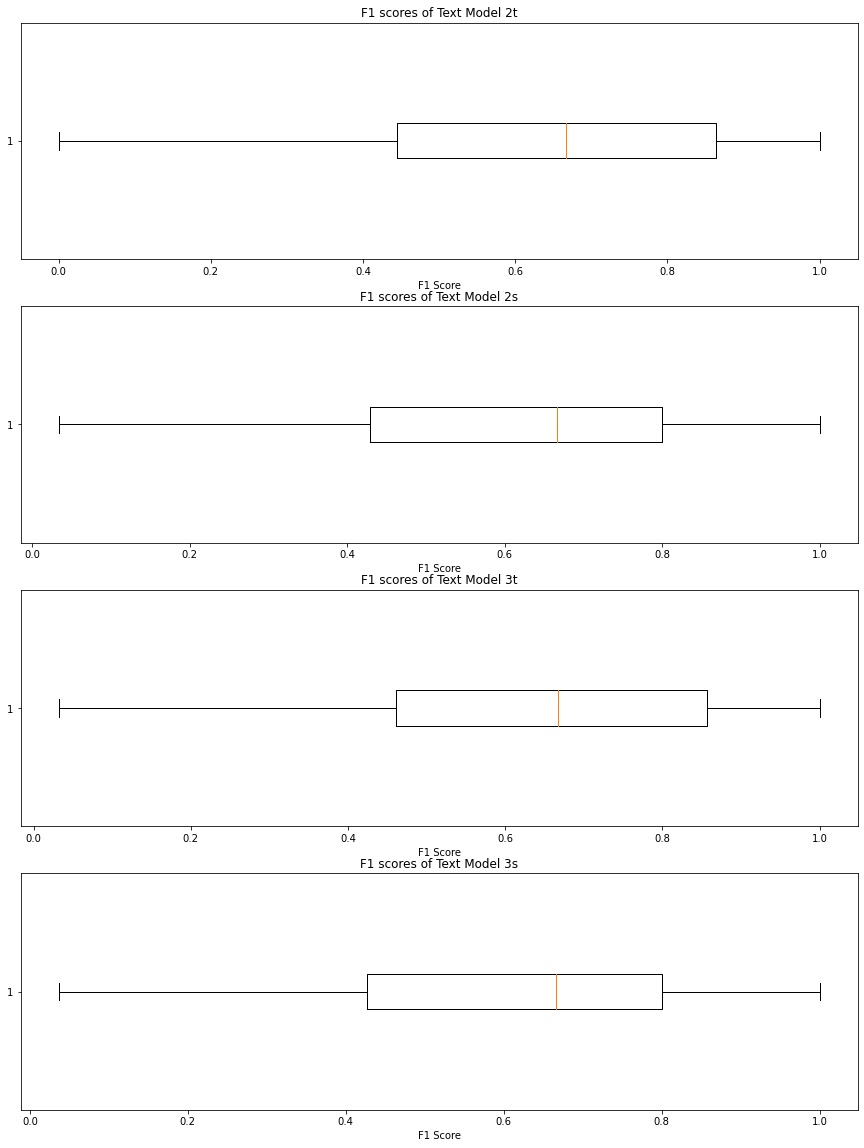

In [32]:
# Check distribution of F1 scores
plt.figure(figsize=(15,5*len(models)))

for i in range(len(models)):
    plt.subplot(len(models), 1, i + 1)
    plt.boxplot(train[f'text_f1_scores_{models[i]}'], vert=False)
    plt.xlabel('F1 Score')
    plt.title(f'F1 scores of Text Model {models[i]}');

In [33]:
# Check F1 score value counts
for i in range(len(models)):
    print(f'Most frequent F1 score of text model {models[i]}')
    print(train[f'text_f1_scores_{models[i]}'].value_counts().head(10))
    print('')

Most frequent F1 score of text model 2t
1.000000    7186
0.666667    5821
0.500000    2791
0.800000    2195
0.400000    1703
0.571429    1038
0.333333     999
0.857143     814
0.285714     749
0.750000     583
Name: text_f1_scores_2t, dtype: int64

Most frequent F1 score of text model 2s
0.666667    7464
1.000000    5789
0.500000    3383
0.800000    2069
0.400000    1930
0.333333    1215
0.571429     992
0.285714     823
0.857143     740
0.750000     564
Name: text_f1_scores_2s, dtype: int64

Most frequent F1 score of text model 3t
1.000000    7223
0.666667    6213
0.500000    2965
0.800000    2169
0.400000    1726
0.333333     976
0.571429     966
0.857143     811
0.285714     789
0.750000     591
Name: text_f1_scores_3t, dtype: int64

Most frequent F1 score of text model 3s
0.666667    7657
1.000000    5803
0.500000    3452
0.800000    2044
0.400000    1965
0.333333    1213
0.571429    1020
0.285714     857
0.857143     713
0.250000     577
Name: text_f1_scores_3s, dtype: int64



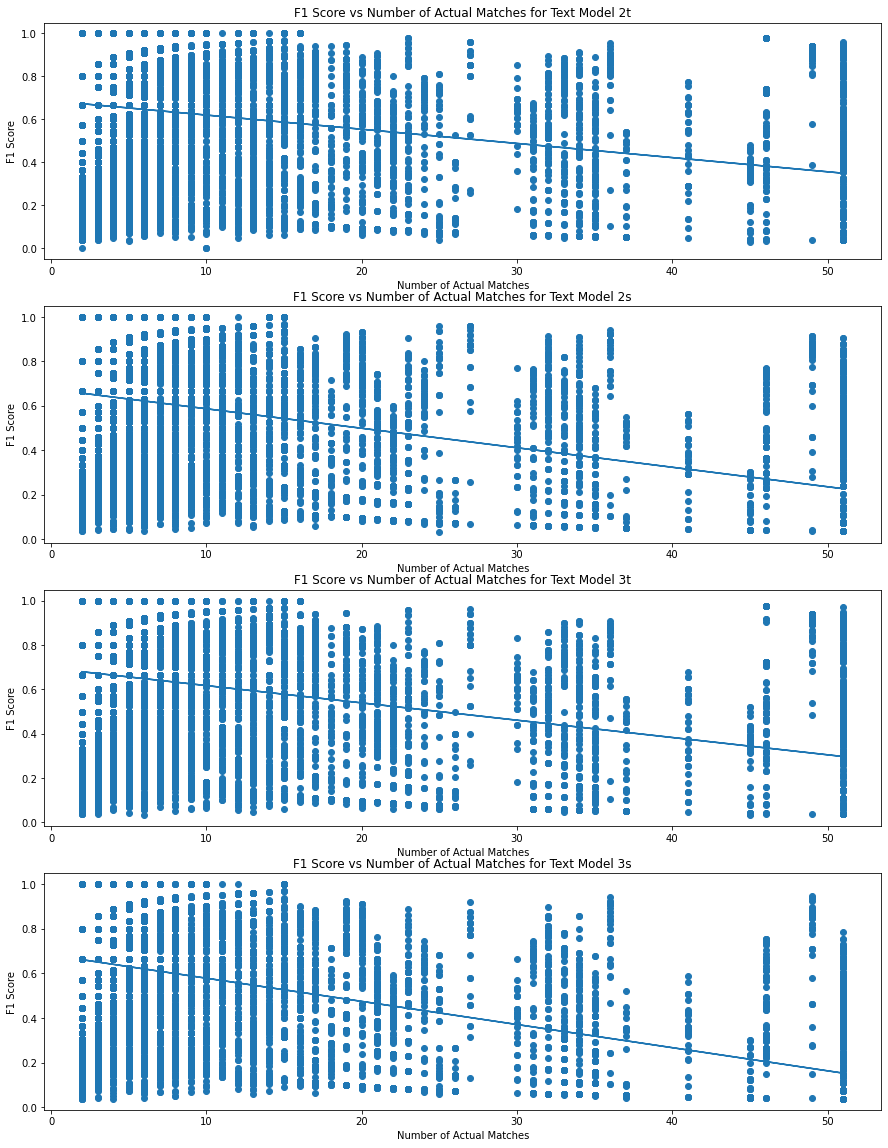

In [34]:
# Check F1 scores by number of matches
plt.figure(figsize = (15,5*len(models)))
x = [(len(match)) for match in train['matches']]

for i in range(len(models)):
    y = train[f'text_f1_scores_{models[i]}'].astype('float64')
    plt.subplot(len(models), 1, i + 1)
    plt.scatter(x, y)
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, [m*i for i in x] + b)
    plt.xlabel('Number of Actual Matches')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score vs Number of Actual Matches for Text Model {models[i]}');

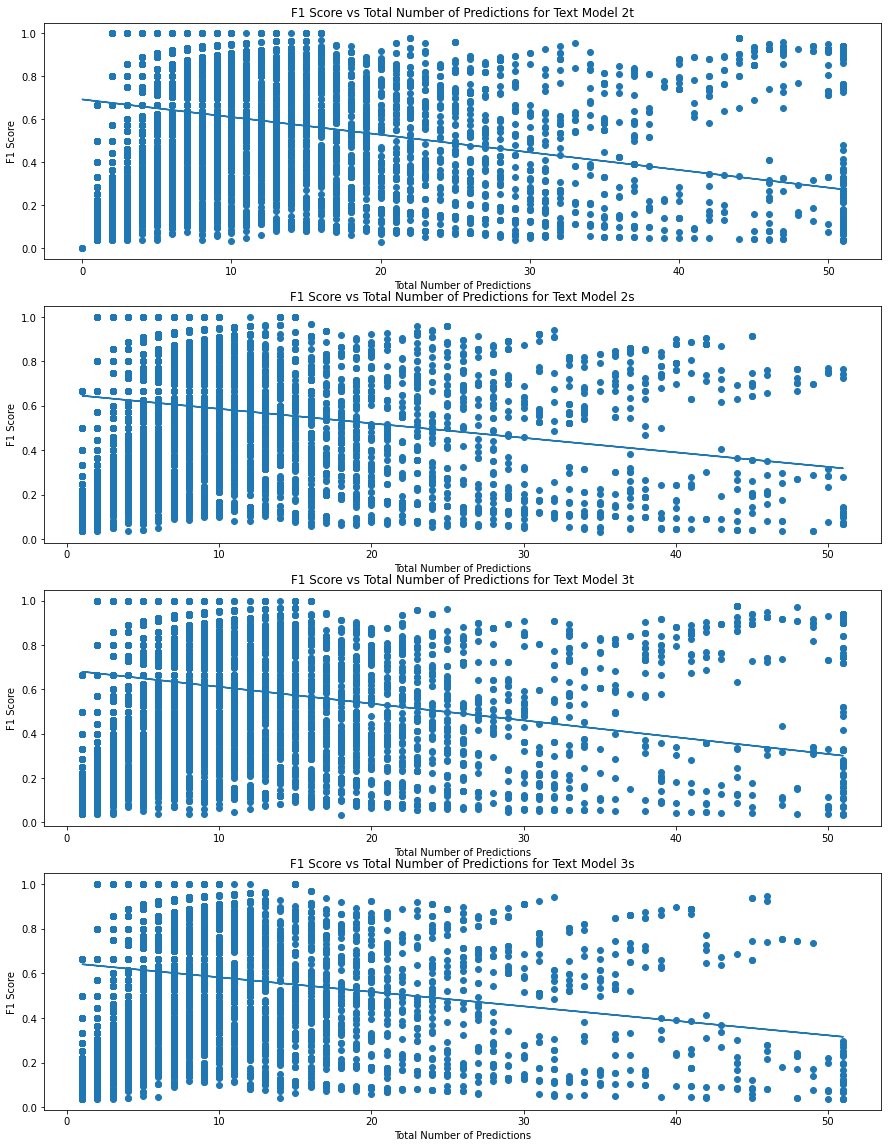

In [35]:
# Check F1 scores by number of predictions
plt.figure(figsize = (15,5*len(models)))

for i in range(len(models)):
    x = [len(pred) for pred in train[f'text_predictions_{models[i]}']]
    y = train[f'text_f1_scores_{models[i]}'].astype('float64')
    plt.subplot(len(models), 1, i + 1)
    plt.scatter(x, y)
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, [m*i for i in x] + b)
    plt.xlabel('Total Number of Predictions')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score vs Total Number of Predictions for Text Model {models[i]}');

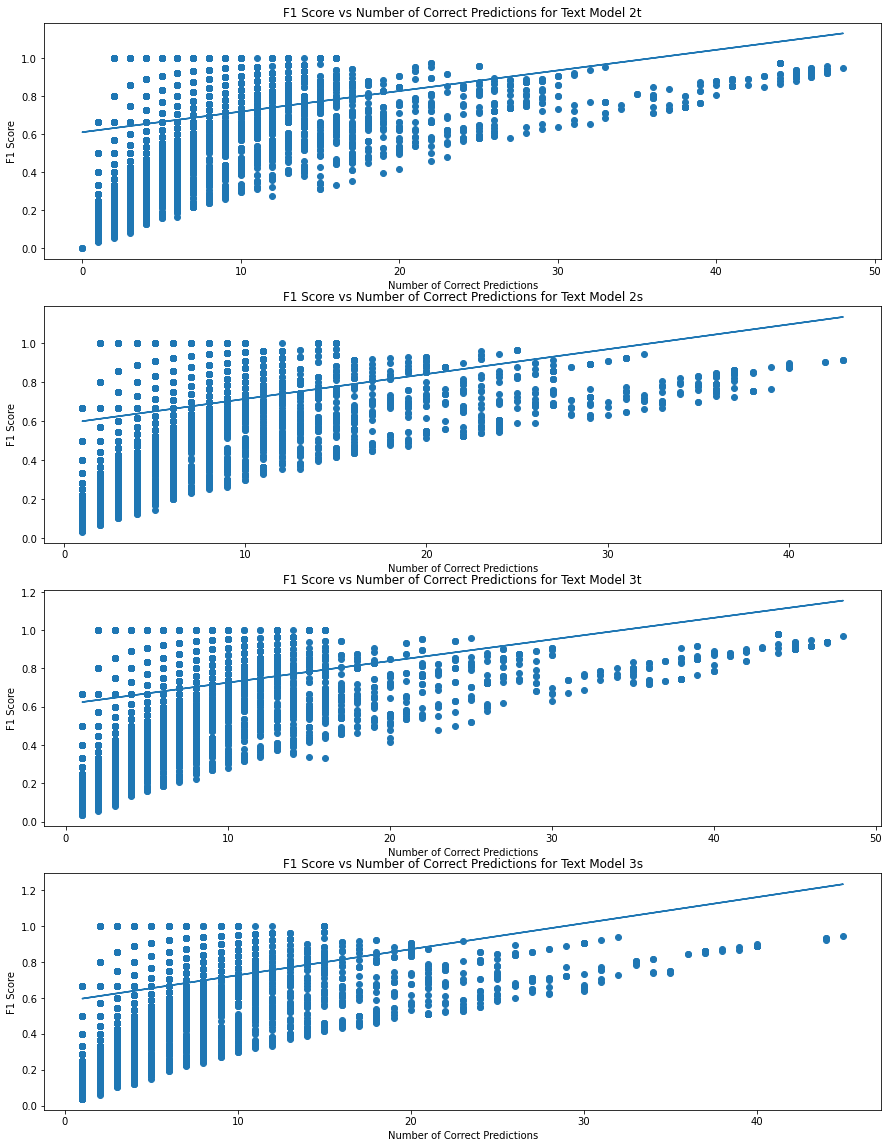

In [36]:
# Check F1 scores by number of correct predictions
plt.figure(figsize = (15,5*len(models)))

for i in range(len(models)):
    x = []
    for j in range(len(train['matches'])):
        x.append(len(np.intersect1d(train['matches'][j], train[f'text_predictions_{models[i]}'][j])))
    y = train[f'text_f1_scores_{models[i]}'].astype('float64')
    plt.subplot(len(models), 1, i + 1)
    plt.scatter(x, y)
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, [m*i for i in x] + b)
    plt.xlabel('Number of Correct Predictions')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score vs Number of Correct Predictions for Text Model {models[i]}');

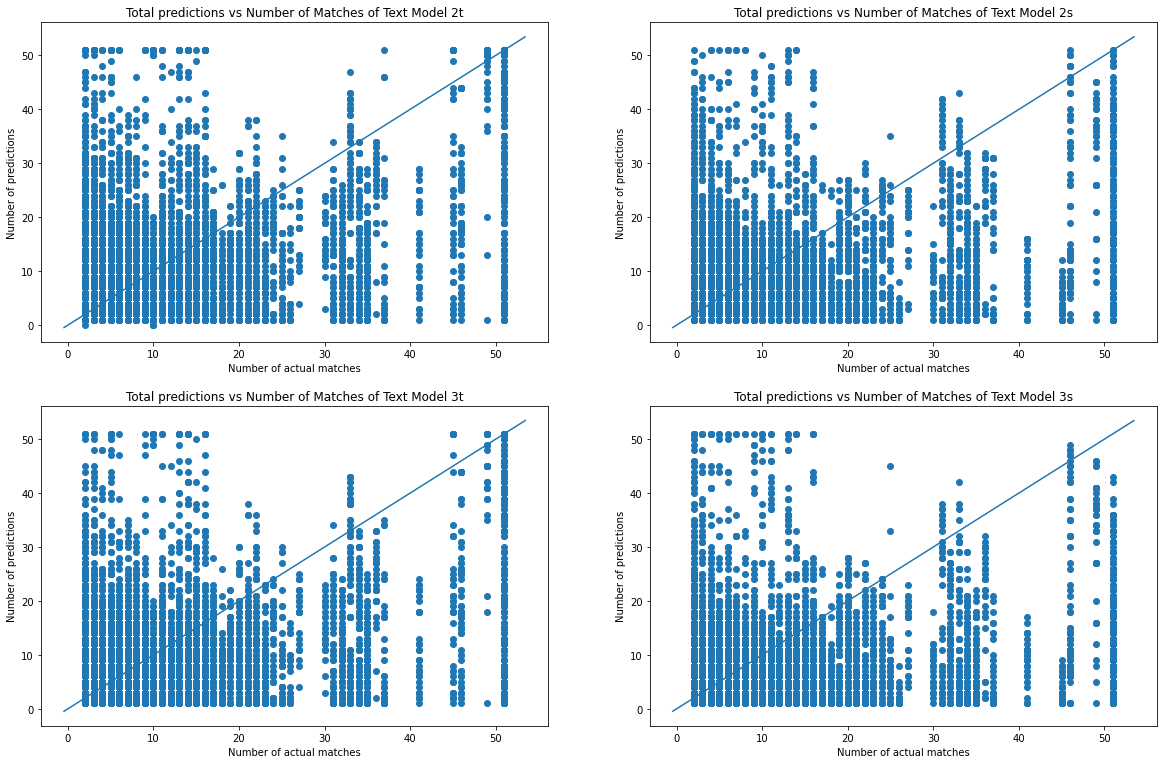

In [37]:
# Check number of predictions vs number of matches
plt.figure(figsize=(20,20))
x = [(len(match)) for match in train['matches']]

for i in range(len(models)):
    y = [len(pred) for pred in train[f'text_predictions_{models[i]}']]
    plt.subplot(len(models) // 2 + 1, 2, i+1)
    plt.scatter(x, y)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints)
    plt.xlabel('Number of actual matches')
    plt.ylabel('Number of predictions')
    plt.title(f'Total predictions vs Number of Matches of Text Model {models[i]}');

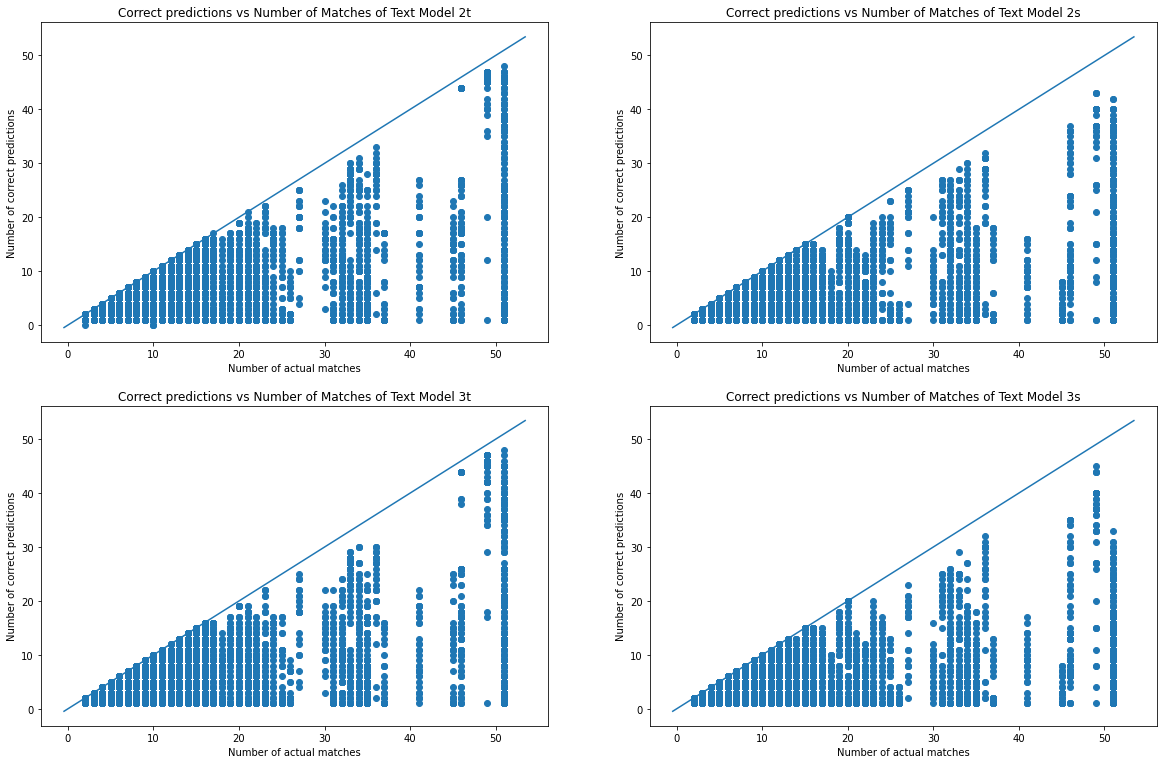

In [38]:
# Check number of correct predictions vs number of matches
plt.figure(figsize=(20,20))
x = [(len(match)) for match in train['matches']]

for i in range(len(models)):
    y = []
    for j in range(len(train['matches'])):
        y.append(len(np.intersect1d(train['matches'][j], train[f'text_predictions_{models[i]}'][j])))
    plt.subplot(len(models) // 2 + 1, 2, i+1)
    plt.scatter(x, y)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints)
    plt.xlabel('Number of actual matches')
    plt.ylabel('Number of correct predictions')
    plt.title(f'Correct predictions vs Number of Matches of Text Model {models[i]}');

### Predicted Titles vs Matches

In [39]:
# Create function to retrieve titles from posting_id matches or predictions
def show_titles(df, posting_id, model=0, matches=True):
    # If we are checking for matching images
    if matches:
        group = df.loc[df['posting_id'] == posting_id]['matches'].values[0]
        message = f'Showing matches of posting_id {posting_id}'

    # If we are checking our predictions
    else:
        group = df.loc[df['posting_id'] == posting_id][f'text_predictions_{model}'].values[0]
        message = f'Showing predictions of model {model} of posting_id {posting_id}'
        
    print(message)
    print('Titles:')
    for i in range(len(group)):
        print(df.loc[df['posting_id'] == group[i]]['title'].values[0])
    if not matches:
        print('')
        print('Tokens:')
        for i in range(len(group)):
            print(df.loc[df['posting_id'] == group[i]][f'tokens_{model[0]}'].values[0])

In [40]:
# Check models with different scores
train.loc[(train['text_f1_scores_2t'] != train['text_f1_scores_2s']) & \
          (train['text_f1_scores_3t'] != train['text_f1_scores_3s'])].head()

posting_id                                 image  \
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg   
6  train_1802986387  00144a49c56599d45354a1c28104c039.jpg   
8    train_86570404  0019a3c6755a194cb2e2c12bfc63972e.jpg   

                                               title label_group  \
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...  2937985045   
3  Daster Batik Lengan pendek - Motif Acak / Camp...  4093212188   
4                  Nescafe \xc3\x89clair Latte 220ml  3648931069   
6                           Jubah anak size 1-12 thn  1835033137   
8  [LOGU] Tempelan kulkas magnet angka, tempelan ...  2359912463   

                                             matches  \
1               [train_3386243561, train_3423213080]   
3               [train_2406599165, train_3342059966]   
4                [train_3369186413, train_921438619]   
6  [train_1802986387, train_1396161074, train_713...   
8  [train_86570404, train_2837452969, train_77364...   

                                            tokens_2  \
1         double tape 3m vhb 12 4 5 double foam tape   
3  daster batik lengan pendek motif acak campur l...   
4                   nescafe xc3 x89clair latte 220ml   
6                                jubah anak 1 12 thn   
8  logu tempelan kulkas magnet angka tempelan ang...   

                                 text_predictions_2t text_f1_scores_2t  \
1  [train_3386243561, train_3423213080, train_197...               0.4   
3  [train_2406599165, train_1744956981, train_352...               0.2   
4                                 [train_3369186413]          0.666667   
6  [train_1802986387, train_1396161074, train_151...               0.4   
8  [train_86570404, train_2269068443, train_11515...          0.333333   

                                 text_predictions_2s text_f1_scores_2s  \
1  [train_3386243561, train_3423213080, train_197...          0.571429   
3  [train_1744956981, train_2406599165, train_352...          0.285714   
4                [train_3369186413, train_921438619]               1.0   
6  [train_1802986387, train_1396161074, train_249...          0.545455   
8                                   [train_86570404]               0.5   

                                            tokens_3  \
1  double tape 3m vhb 12 mm x 4 5 m original doub...   
3  daster batik lengan pendek motif acak campur l...   
4                   nescafe xc3 x89clair latte 220ml   
6                           jubah anak size 1 12 thn   
8  logu tempelan kulkas magnet angka tempelan ang...   

                                 text_predictions_3t text_f1_scores_3t  \
1  [train_3386243561, train_3423213080, train_197...               0.5   
3  [train_1744956981, train_2406599165, train_352...          0.222222   
4                                 [train_3369186413]          0.666667   
6  [train_1802986387, train_1396161074, train_249...          0.545455   
8  [train_86570404, train_2269068443, train_11515...          0.333333   

                                 text_predictions_3s text_f1_scores_3s  
1  [train_3386243561, train_3423213080, train_211...          0.571429  
3  [train_1744956981, train_2406599165, train_352...          0.285714  
4                [train_3369186413, train_921438619]               1.0  
6  [train_1802986387, train_1396161074, train_249...          0.461538  
8                                   [train_86570404]               0.5

In [41]:
# Show matches of 'train_2406599165'
show_titles(train, 'train_2406599165', model=0, matches=True)

Showing matches of posting_id train_2406599165
Titles:
Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi
DASTER PIYAMA KATUN JEPANG(TIDAK BISA PILIH MOTIF & WARNA)


In [42]:
# Show predictions of 'train_2406599165' for model 2t, which had F1 score of 0.2
show_titles(train, 'train_2406599165', model='2t', matches=False)

Showing predictions of model 2t of posting_id train_2406599165
Titles:
Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi
Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi
Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter busui
Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter IKHLAS
Daster Batik Bali Lengan pendek - Motif Acak / Campur - Leher Kancing BUSUI - BUMIL - Batik Alhadi
Daster Karakter - Leher Kancing (DPT001-00) Busui Alhadi Terlaris Saat ini
Daster payung klok motif acak/campur leher kancing busui bumil (DPT001-00) Batik FA
Daster Payung Bali JUMBO XXL, Motif Acak / Campur, Leher Kancing Bumil Busui (DPT005), Batik Alhadi

Tokens:
daster batik lengan pendek motif acak campur leher kancing dpt001 00 batik karakter alhadi
daster batik lengan pendek motif acak campur leher kancing dpt001 00 batik k

In [43]:
# Show predictions of 'train_2406599165' for model 2s which had F1 score of 0.285714
show_titles(train, 'train_2406599165', model='2s', matches=False)

Showing predictions of model 2s of posting_id train_2406599165
Titles:
Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi
Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi
Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter busui
Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter IKHLAS
Daster Batik Bali Lengan pendek - Motif Acak / Campur - Leher Kancing BUSUI - BUMIL - Batik Alhadi

Tokens:
daster batik lengan pendek motif acak campur leher kancing dpt001 00 batik karakter alhadi
daster batik lengan pendek motif acak campur leher kancing dpt001 00 batik karakter alhadi
daster batik lengan pendek motif acak campur leher kancing dpt001 00 batik karakter busui
daster batik lengan pendek motif acak campur leher kancing dpt001 00 batik karakter ikhlas
daster batik bali lengan pendek motif acak campur leher kancing

In [44]:
# Show matches of 'train_3386243561'
show_titles(train, 'train_3386243561', model=0, matches=True)

Showing matches of posting_id train_3386243561
Titles:
Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE
Double Tape VHB 3M ORIGINAL 12mm x 4.5mm Busa Perekat


In [45]:
# Show predictions of 'train_3386243561' for model 2t, which had F1 score of 0.4
show_titles(train, 'train_3386243561', model='2t', matches=False)

Showing predictions of model 2t of posting_id train_3386243561
Titles:
Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE
Double Tape VHB 3M ORIGINAL 12mm x 4.5mm Busa Perekat
DOUBLE TAPE BUSA 3M Pe Foam Tape 24mm x 4M ORIGINAL
DOUBLE TAPE BUSA 3M Pe Foam Tape 24mm x 4M ORIGINAL
DOUBLE TAPE BUSA 3M Pe Foam Tape 24mm x 4M ORIGINAL
Double Tape 1/4 Inch JOYKO / Double Tip
Double Tip / Double Sided Tape Perekat 2 Sisi Joyko 6 mm x 15 yard Double Tape
3M VHB 12mm x 4.5m Double Tape Foam Merah Otomotif & Building ORI

Tokens:
double tape 3m vhb 12 4 5 double foam tape
double tape vhb 3m 12mm 4 5mm busa perekat
double tape busa 3m pe foam tape 24mm 4m
double tape busa 3m pe foam tape 24mm 4m
double tape busa 3m pe foam tape 24mm 4m
double tape 1 4 joyko double tip
double tip double sided tape perekat 2 sisi joyko 6 15 double tape
3m vhb 12mm 4 5m double tape foam merah otomotif building


In [46]:
# Show predictions of 'train_3386243561' for model 2s, which had F1 score of 0.571429
show_titles(train, 'train_3386243561', model='2s', matches=False)

Showing predictions of model 2s of posting_id train_3386243561
Titles:
Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE
Double Tape VHB 3M ORIGINAL 12mm x 4.5mm Busa Perekat
DOUBLE TAPE BUSA 3M Pe Foam Tape 24mm x 4M ORIGINAL
DOUBLE TAPE BUSA 3M Pe Foam Tape 24mm x 4M ORIGINAL
DOUBLE TAPE BUSA 3M Pe Foam Tape 24mm x 4M ORIGINAL

Tokens:
double tape 3m vhb 12 4 5 double foam tape
double tape vhb 3m 12mm 4 5mm busa perekat
double tape busa 3m pe foam tape 24mm 4m
double tape busa 3m pe foam tape 24mm 4m
double tape busa 3m pe foam tape 24mm 4m


In [47]:
# Show matches of 'train_3369186413'
show_titles(train, 'train_3369186413', model=0, matches=True)

Showing matches of posting_id train_3369186413
Titles:
Nescafe \xc3\x89clair Latte 220ml
Nescafe Eclair Latte Pet 220 Ml


In [48]:
# Show predictions of 'train_3369186413' for model 2t, which had F1 score of 0.66666
show_titles(train, 'train_3369186413', model='2t', matches=False)

Showing predictions of model 2t of posting_id train_3369186413
Titles:
Nescafe \xc3\x89clair Latte 220ml

Tokens:
nescafe xc3 x89clair latte 220ml


In [49]:
# Show predictions of 'train_3369186413' for model 2s, which had F1 score of 1.0
show_titles(train, 'train_3369186413', model='2s', matches=False)

Showing predictions of model 2s of posting_id train_3369186413
Titles:
Nescafe \xc3\x89clair Latte 220ml
Nescafe Eclair Latte Pet 220 Ml

Tokens:
nescafe xc3 x89clair latte 220ml
nescafe eclair latte pet 220 ml


### Images of Predicted Titles

This section will examine the images of the above predicted titles.

In [50]:
from PIL import Image

In [51]:
# Set image directory
train_dir = '../datasets/train_images/'

In [52]:
# Create function to plot images of matches or text predictions
def show_images_text_preds(df, posting_id, model=0, matches=True, columns=3, width=30, height=10):
    
    # If we are checking for matching images
    if matches:
        group = df.loc[df['posting_id'] == posting_id]['matches'].values[0]

    # If we are checking our text predictions
    else:
        group = df.loc[df['posting_id'] == posting_id][f'text_predictions_{model}'].values[0]

    height = max(height, int(len(group)/columns) * height)
    plt.figure(figsize=(width, height))

    for i in range(len(group)):
        plt.subplot(len(group) // columns + 1, columns, i + 1)
        im = Image.open(train_dir + df.loc[df['posting_id'] == group[i]]['image'].values[0])
        plt.imshow(im)
        plt.title(df.loc[df['posting_id'] == group[i]]['title'].values[0])

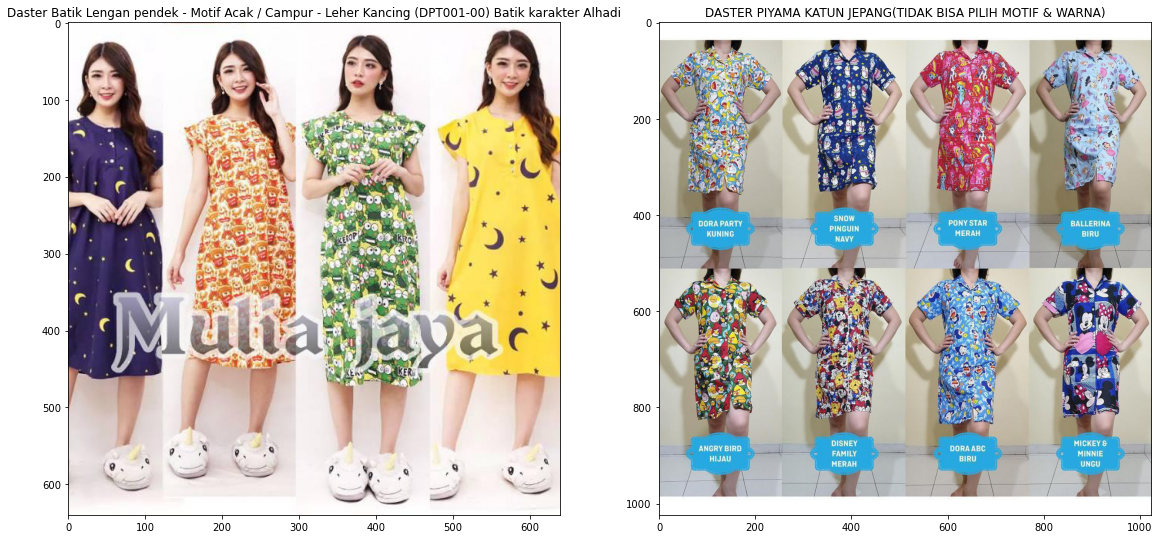

In [53]:
# Show matches of 'train_2406599165'
show_images_text_preds(train, 'train_2406599165', matches=True)

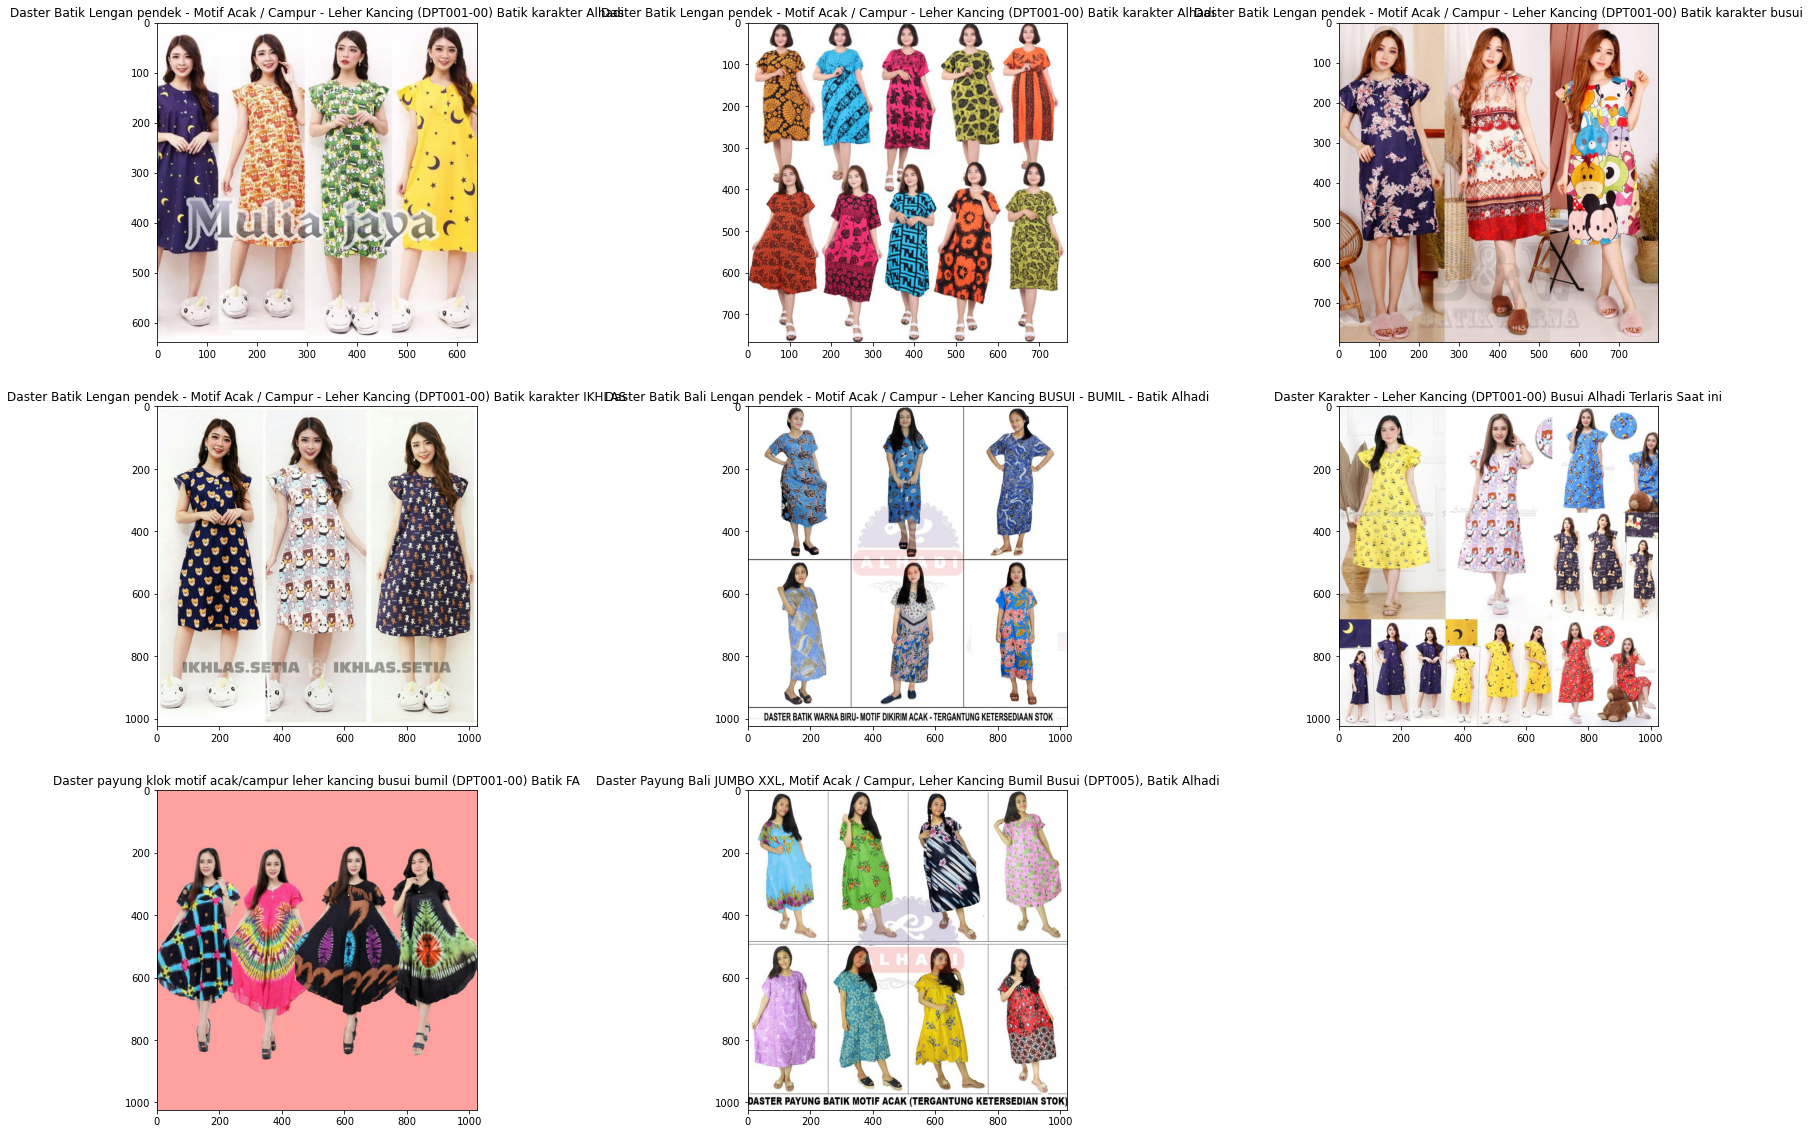

In [54]:
# Show predictions of 'train_2406599165' for model 2t, which had F1 score of 0.2
show_images_text_preds(train, 'train_2406599165', model='2t', matches=False)

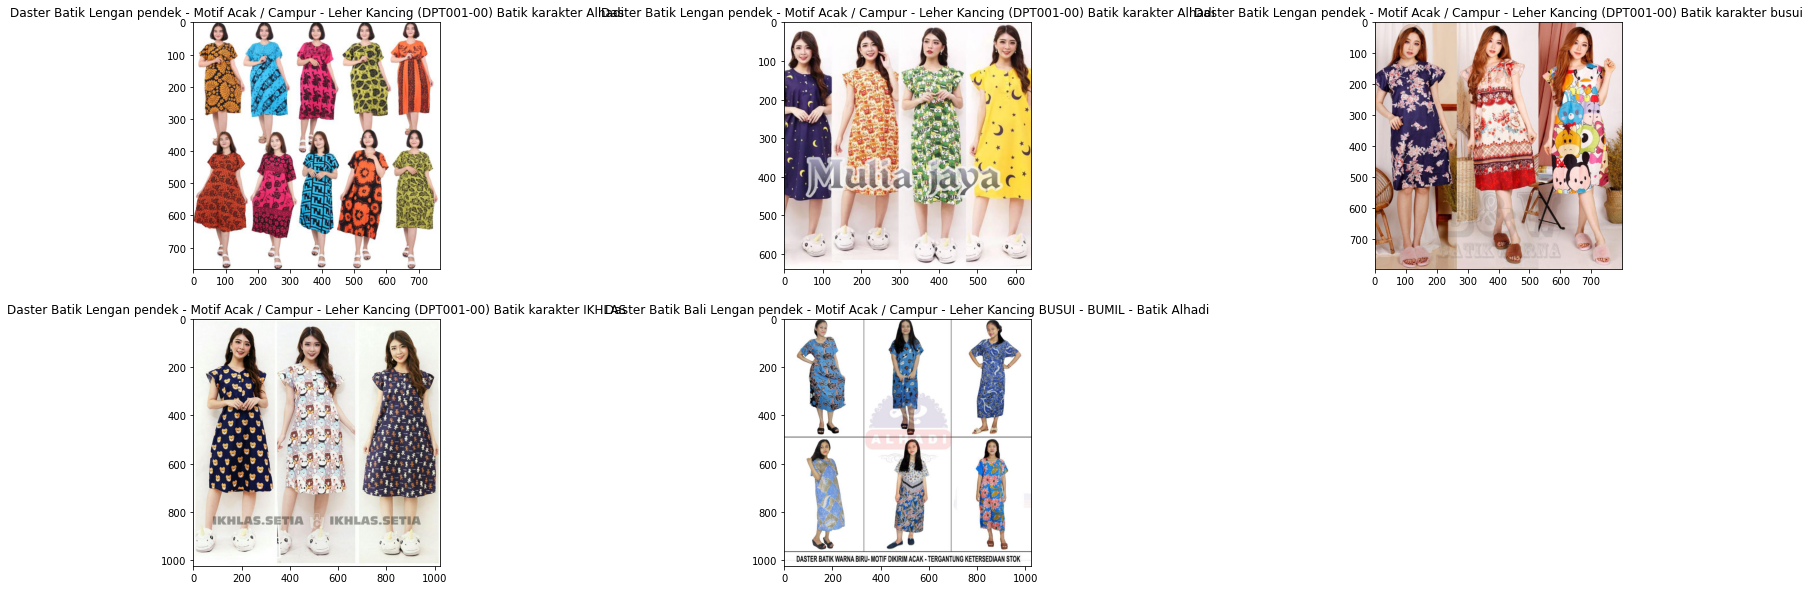

In [55]:
# Show predictions of 'train_2406599165' for model 2s which had F1 score of 0.285714
show_images_text_preds(train, 'train_2406599165', model='2s', matches=False)

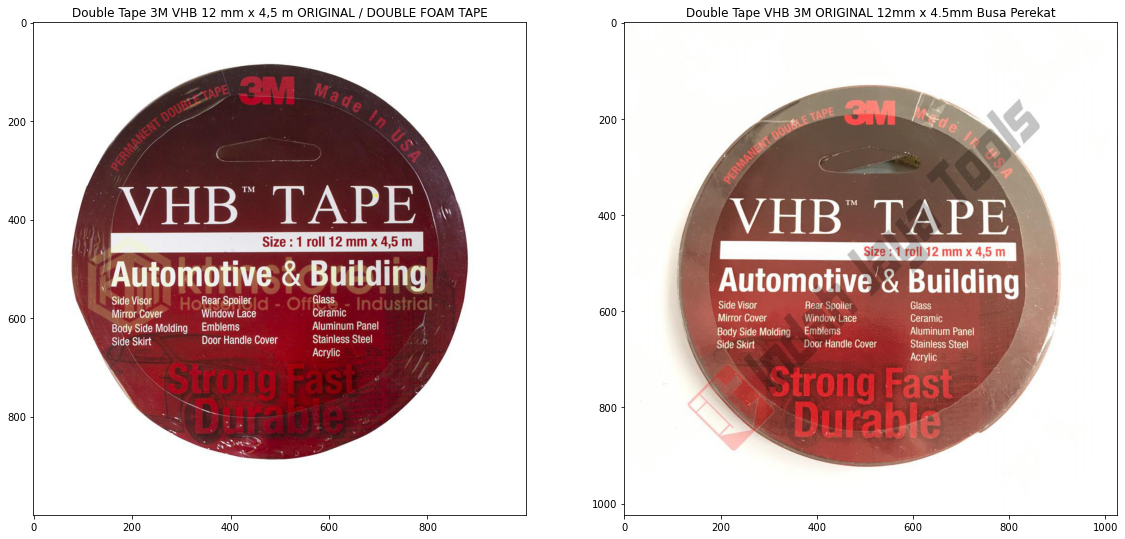

In [56]:
# Show matches of 'train_3386243561'
show_images_text_preds(train, 'train_3386243561', matches=True)

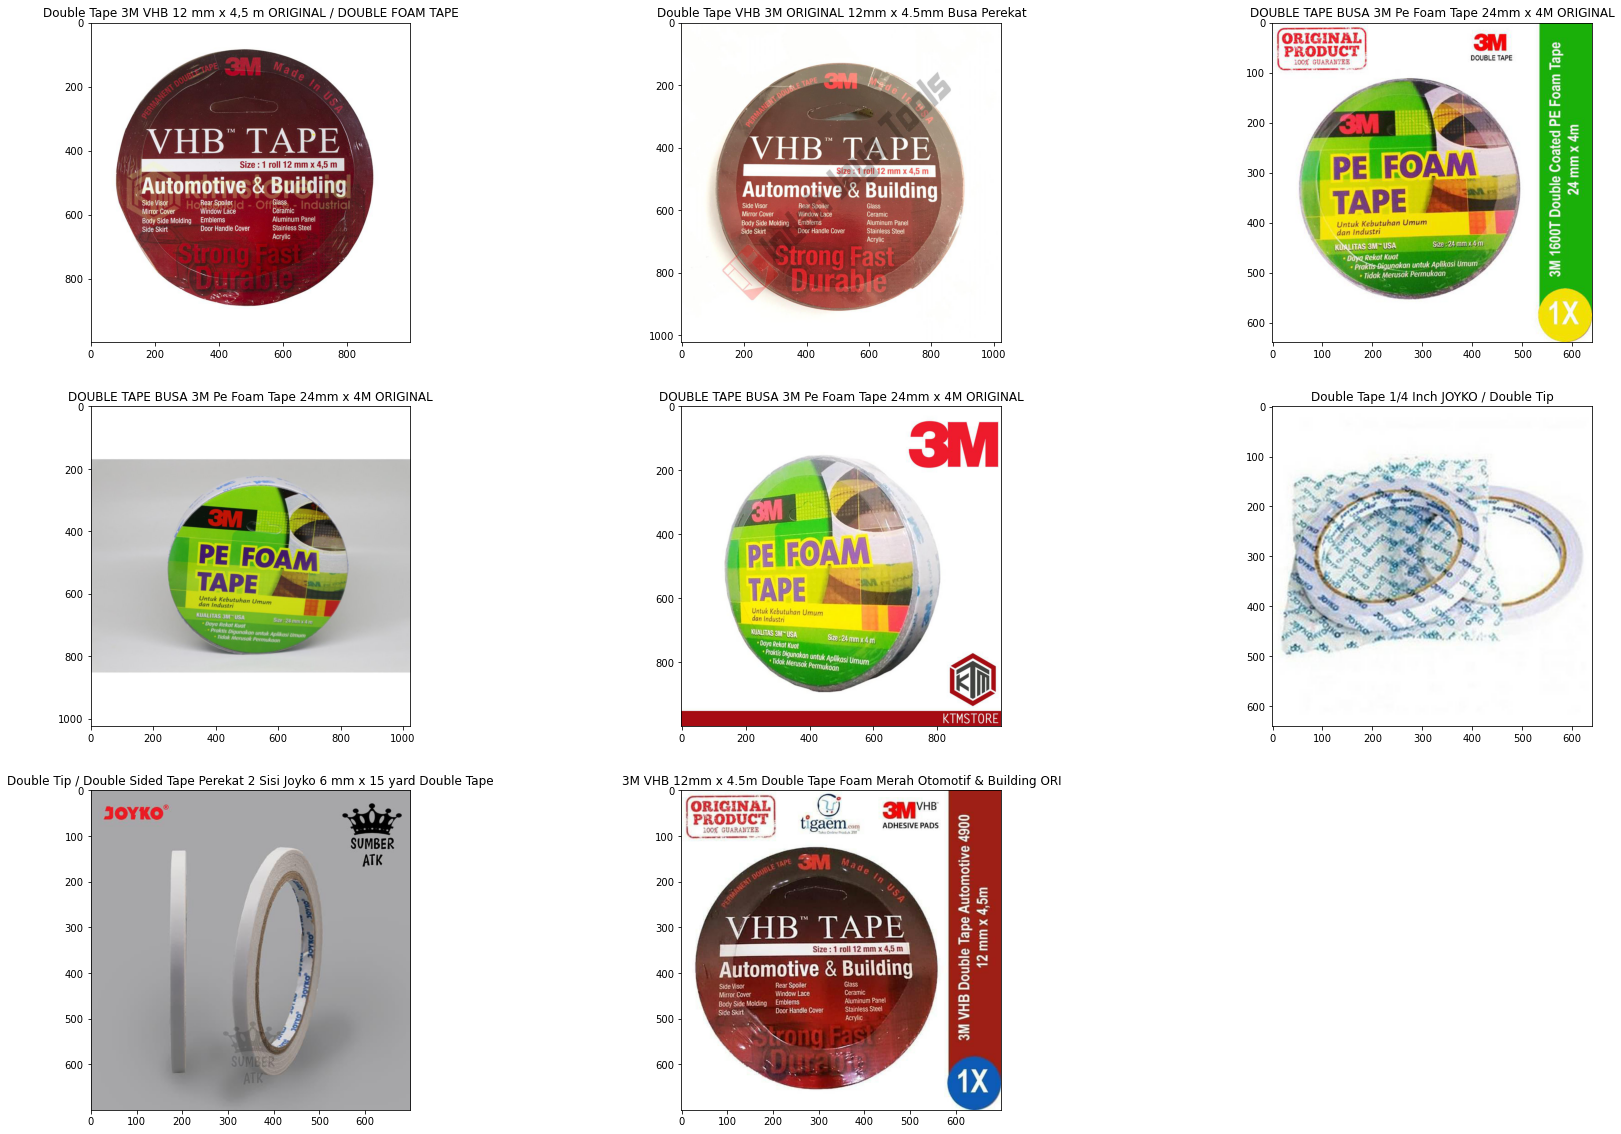

In [57]:
# Show predictions of 'train_3386243561' for model 2t, which had F1 score of 0.4
show_images_text_preds(train, 'train_3386243561', model='2t', matches=False)

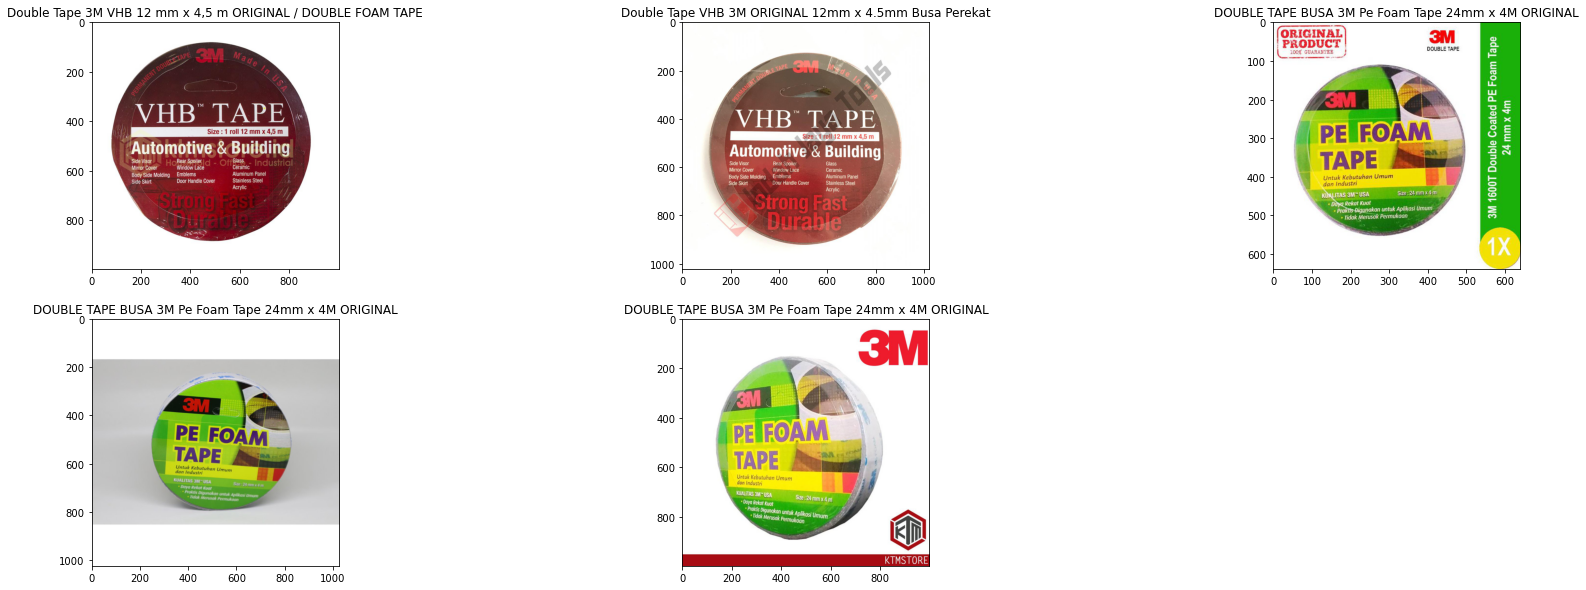

In [58]:
# Show predictions of 'train_3386243561' for model 2s, which had F1 score of 0.571429
show_images_text_preds(train, 'train_3386243561', model='2s', matches=False)

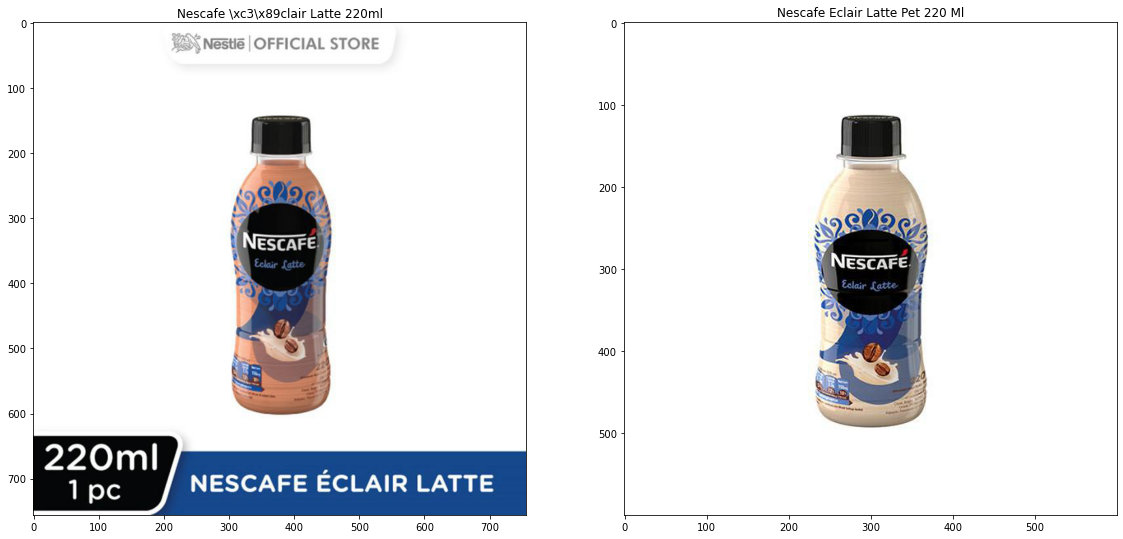

In [59]:
# Show matches of 'train_3369186413'
show_images_text_preds(train, 'train_3369186413', model=0, matches=True)

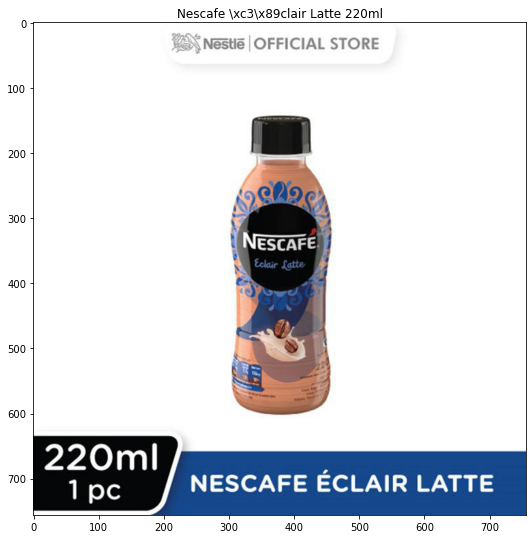

In [60]:
# Show predictions of 'train_3369186413' for model 2t, which had F1 score of 0.66666
show_images_text_preds(train, 'train_3369186413', model='2t', matches=False)

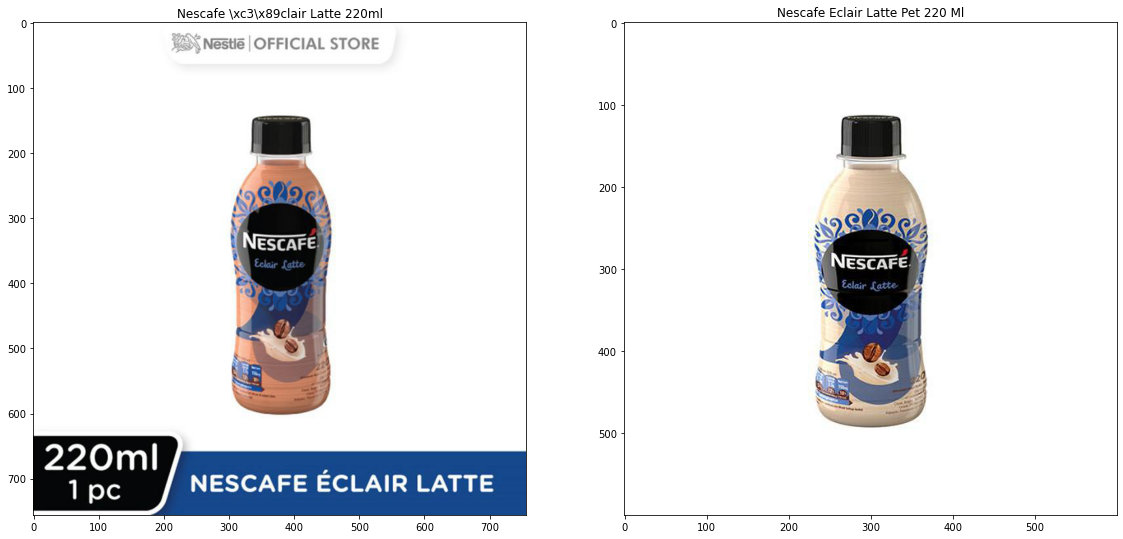

In [61]:
# Show predictions of 'train_3369186413' for model 2s, which had F1 score of 1.0
show_images_text_preds(train, 'train_3369186413', model='2s', matches=False)

### Titles of Different Languages

In [62]:
# Check a label group with titles of different languages
train.loc[train['label_group'] == 1163569239]

posting_id                                 image  \
1088   train_1671347582  089060edc61ec626e6b4943cf18dd651.jpg   
1365   train_1175819799  0ad5228fee2f95f68253719c32fc4f5b.jpg   
1889   train_1525859862  0e9286fbfd1a0c00287c2c93a4738b9a.jpg   
1932   train_1261404451  0ee29d56042b2ff25d171b0f090463a8.jpg   
2223   train_1865413913  11007ac5a612addbb5df96445e438b14.jpg   
2822    train_943427380  158ac22bf48f9c2edfde81e2502af076.jpg   
4111   train_3789517483  1f54f4cee1e5c094b00e0e423971f283.jpg   
5343   train_3171223531  286db00383814bfdb2191d7a9dee6d22.jpg   
7558    train_623546295  3907af8ee31d85d32ddaf03a067099ad.jpg   
7576   train_3598710032  3922820f64ae0759bdd2a3e44e5466da.jpg   
7994   train_2375162891  3c340e6695bf312295fda97e8723262a.jpg   
8080   train_3071392783  3cf6b66a18ef9dda58751e039052f884.jpg   
8473   train_2960536609  3fb255b554dcd80003b8dd7a68f5ad83.jpg   
8474   train_1149371320  3fb255b554dcd80003b8dd7a68f5ad83.jpg   
9251    train_219504178  4593d9bf1f99f9443dc755a3f20e553b.jpg   
10353   train_518547082  4d9c056f5098a6fff9c3d95b79b61cd2.jpg   
12569   train_242506613  5e9bb727adf7d1191bcdf21db8bbd67a.jpg   
13106   train_349984975  629d57d5b6b77b5a8f4ebd100f7bed8f.jpg   
13528  train_1848632939  65e86fc1bc7236d4fe73d360c9e9d7eb.jpg   
13984  train_3967271817  695426bad92ebf883168161f705210f0.jpg   
13985  train_2309045515  695426bad92ebf883168161f705210f0.jpg   
14161   train_100918337  6a7d848509abb9a96278317bf487f521.jpg   
14317   train_612230357  6ba51b66ee5f6db68d57774b32401bcc.jpg   
17709   train_913153922  854085407426069af0e91792771a20fa.jpg   
18187   train_450257935  890bfa9eac63d0a0ab5c8df9b895331f.jpg   
18188  train_1639533062  890bfa9eac63d0a0ab5c8df9b895331f.jpg   
18289  train_2378747866  89f563296c330cdfa8d191f2ba20e789.jpg   
19153  train_2305367958  906dbc7ae48691d74482c70efc911745.jpg   
20466   train_726415384  99b4b690b3bf1fa2fa5fdad8625323ad.jpg   
20732   train_948110932  9b8d38f72da8ad07aa0ec4506f939c4f.jpg   
21281  train_1041715554  9fd5f06a3893fd142f9a87ab2c40b9fb.jpg   
21829   train_149240701  a4092408f5fa33028c0c3524191ccae0.jpg   
22617  train_4070413770  a9d2d8c1c7114cece06368e3be609cef.jpg   
22710  train_2901880479  aa96a14a6aa73c01dd77b7899b158029.jpg   
25084   train_897619948  bb93825152c393dc33ae99c8e7a2d2df.jpg   
25468  train_1935153677  be9a41b6f989a2879f5b6bc4ff012395.jpg   
25514  train_4211797822  bf000d68acea3de3119cd7f6d2e28da8.jpg   
25807  train_1369435429  c0df950a079e81dc380cc186468285f6.jpg   
26207   train_613832447  c411136518833f7ea31e253f31920d47.jpg   
26346  train_2624032383  c530e0453721cd2de581f6ede0c2c94e.jpg   
26394  train_2280558444  c582a72935925b39c5d4a06e6d0bfa77.jpg   
26856  train_1182906906  c8f130dac43c77df588ccdee4f249821.jpg   
27544  train_1191962025  ce3f811414a4d7946f68dc2de8022cf5.jpg   
27935  train_3700503493  d12be002596bc72e68ccacb72aaa14a2.jpg   
28317  train_3207964616  d3d5c196b3c3012f0692589bbb306971.jpg   
28953  train_2529405184  d8b11a65547116b4ef0b9216a06ec82c.jpg   
29156  train_4139159388  da7f45220477ce62e3f38fdb301a1025.jpg   
30203   train_799917659  e209329f2e612a7163a212acb029b43a.jpg   
31240  train_1630060072  ea3545fa03f1759a82eef68eabf0a682.jpg   
32664   train_282632898  f4b5a45da9b17a26324261158486873d.jpg   
33633  train_3240884969  fb8fc0da0fe7a52a389147d7e44c0f3d.jpg   

                                                   title label_group  \
1088                        SCARLETT SERUM - BEBAS PILIH  1163569239   
1365                       SCARLETT WHITENING ACNE SERUM  1163569239   
1889   SERUM SCARLETT ACNE & BRIGHTLY- SERUM WAJAH SC...  1163569239   
1932        Scarlett Whitening Brightly Ever After Serum  1163569239   
2223                            SCARLETT serum wajah NEW  1163569239   
2822   SERUM SCARLETT ACNE & BRIGHTLY- FACE SERUM ORI...  1163569239   
4111   SCARLETT Whitening Brightly Ever After Serum /...  1163569239   
5343        SCARLETT WHITENING BRIGHTLY EVER AFTER SERUM

In [63]:
# Average F1 score of model 2t
np.mean(train['text_f1_scores_2t'].loc[train['label_group'] == 1163569239])

0.8253602212862193

In [64]:
# Average F1 score of model 2s
np.mean(train['text_f1_scores_2s'].loc[train['label_group'] == 1163569239])

0.6547745370335588

In [65]:
# Average F1 score of model 3t
np.mean(train['text_f1_scores_3t'].loc[train['label_group'] == 1163569239])

0.7566437506696339

In [66]:
# Average F1 score of model 3s
np.mean(train['text_f1_scores_3s'].loc[train['label_group'] == 1163569239])

0.45986462655949073

In [67]:
# Check a label group with titles of different languages
train.loc[train['label_group'] == 159351600]

posting_id                                 image  \
1167    train_207039286  09165142230c0d600c02a66f62dbee5d.jpg   
2069   train_1619338643  0ff3d417c454a614596da0f160e85b83.jpg   
2542   train_3721308865  136d7ea9fefe1cc04b6a8dfd965cbc9e.jpg   
3140   train_1851882944  18244a8fdbb3aa0b5afb6c31d99134a5.jpg   
3989   train_1236075269  1e4b5a9adc92e50df500e24d935fe0db.jpg   
4024   train_2855329700  1e8f09fca97fca7c88a25afa618a10ff.jpg   
4823   train_1997808959  24735427cab6ac1eb36180269ce0168e.jpg   
4927   train_2840508723  25313d734a75035935dfc008aa0fc833.jpg   
5489   train_2729160884  296d7b2a49d7e94fbde30b9bf7d75447.jpg   
5946   train_2902736490  2d0e11ade5ccb02845e71f27fd671ebd.jpg   
6121   train_1789512220  2e6e8d1158bc6de9a5aa4ac66aec8eac.jpg   
6378   train_2172967167  304b382aa8df8479951538ad84d546fa.jpg   
6633   train_3083046401  32352fa92cf5f92a4d1b70623194f453.jpg   
6812   train_3596545373  337bc01905cceb7e1c2be8d00acb5683.jpg   
8730   train_1673660532  419eecb69bd831da8bacf2019a4a40e1.jpg   
8739    train_675983017  41ad046df8c862fd9401750f3b56a2aa.jpg   
9576    train_799363063  47d651ec8069407b3f2e8fdcfe3f4421.jpg   
10695  train_2034561720  5053cb90aa876f4c5f29070ee21d309f.jpg   
10933  train_1459295979  522621448752cb048276636276a15cea.jpg   
11597  train_1473844208  57236e0fa8170038f52a00606f289ebc.jpg   
11612  train_2283849789  575020bd40332da58c5f89b7f28eae73.jpg   
11724    train_30488954  582167ff41f2864947e2754809a9d093.jpg   
11811  train_2937433253  58d7e6a9a5bf40bc752a232d584a36d9.jpg   
12621  train_3851641413  5ef8b06e47c941fa793a1c08b1338b94.jpg   
13198  train_3274592078  636cee6475808387604018f083edd2a4.jpg   
13309  train_2847244918  643b991fca0ee8a6540d3d7e27e790f1.jpg   
14562  train_4286138740  6d9f842b1db754142fc64a726d6b19b1.jpg   
14877  train_3560974982  702fe543211c2d2234828b7f0cd41742.jpg   
16784  train_2072061027  7e63048e86bc35e6bf927f00e6746e4e.jpg   
17168  train_3134779648  815117e3e54a7cee62681ecee0086f06.jpg   
17965  train_3633103106  87344118907939a5efaea0a3865b65c1.jpg   
18288  train_1906102508  89f3a5c1702015498f321162df3255f2.jpg   
18817  train_3869843407  8de06ac326758a2c85cadfcd1cec6b9f.jpg   
21873  train_4280580992  a46a4e9478fc1976efa8355bd5a3df41.jpg   
23665  train_3671554064  b1633edd584155e8b86ab69477efbdc5.jpg   
24041  train_2683750575  b401154c9b84fe4a843f809358bc4249.jpg   
24564  train_1142799664  b83c819c4ed72c2b86c1ba945db841bc.jpg   
24869  train_2513892071  ba414728d75856bf59440c6cb6215092.jpg   
25117  train_3980820034  bbe4ea3bb36ccf6308d6220edfb13343.jpg   
27060  train_3055192895  ca6d3437674a92065e967ec2fab61a14.jpg   
30540  train_1495753847  e44cb22c562dce9e10f93255cef7852d.jpg   
30842  train_2266041454  e6efd30edc315730027c3fc5723b3bab.jpg   
31063  train_2036340727  e8d1e7dcf8f4f70b75d282095f1ced26.jpg   
31771  train_2338443281  ee1bcca3ae3060b33dff061c2df7f8b5.jpg   
31834   train_467196729  ee92c2028b6b0216a778629363ccfec3.jpg   
32089  train_1061695682  f08c575873d6d31183d9e27995d73f22.jpg   
32552  train_2258929039  f3f33a092d06af8a62e06afb22355a05.jpg   
32575  train_4238545699  f42a18302339c01ca82a91eaff2ae702.jpg   
32576  train_2160269935  f42a18302339c01ca82a91eaff2ae702.jpg   
32987  train_1141098045  f6f3ed2a8d3ad16092c928f77998a346.jpg   
33664  train_3414293340  fbced36545a91bf5596647250db71dcc.jpg   

                                                   title label_group  \
1167   Ready Stock - Gluta Collagen Soap By Beautetox...   159351600   
2069      GLUTA COLLAGEN SOAP BY BEAUTETOX SKINSUPERSTAR   159351600   
2542   KIRIM SETIAP HARI!! GLUTA COLLAGEN SOAP BEAUTE...   159351600   
3140          [Ready & Resmi] Gluta Soap Beautetox Viral   159351600   
3989   READY STOK [THE3ANGLE-KD] Gluta Collagen Beaut...   159351600   
4024              [READY SIAP KIRIM] GLUTA COLLAGEN SOAP   159351600   
4823   (DISKON 11-11 BURUAN ORDER) Sabun Whitening Gl...   159351600   
4927     [FREE JARING SABUN] Gluta Collagen Soap [READY]

In [68]:
# Average F1 score of model 2t
np.mean(train['text_f1_scores_2t'].loc[train['label_group'] == 159351600])

0.5239940809563431

In [69]:
# Average F1 score of model 2s
np.mean(train['text_f1_scores_2s'].loc[train['label_group'] == 159351600])

0.5092782554265348

In [70]:
# Average F1 score of model 3t
np.mean(train['text_f1_scores_3t'].loc[train['label_group'] == 159351600])

0.40418131378998823

In [71]:
# Average F1 score of model 3s
np.mean(train['text_f1_scores_3s'].loc[train['label_group'] == 159351600])

0.32866181643701203

### Combined Scores

Examine if the set union of the predictions from different models improves the scores

In [76]:
# Average score of set union of model 2t and model 2s
combined_2 = []

for i in range(train.shape[0]):
    combined_2.append(np.union1d(train['text_predictions_2t'].iloc[i], train['text_predictions_2s'].iloc[i]))

In [78]:
# Check average score
np.mean(scores(matches, combined_2))

0.6437477977999726

In [79]:
# Average score of set union of model 3t and model 3s
combined_3 = []

for i in range(train.shape[0]):
    combined_3.append(np.union1d(train['text_predictions_3t'].iloc[i], train['text_predictions_3s'].iloc[i]))

In [80]:
# Check average score
np.mean(scores(matches, combined_3))

0.648996183936944

## Observations

**Product group titles**
- Products in different label groups could have very similar titles
- Products in the same label group could also have different titles

**Scores**
- Cosine distance scored higher than Euclidean distance in general
- Making a higher number of predictions generally results in lower scores
- 1.0 and 0.6667 are the most frequent scores for the text models

**TF-IDF vs Semantic Embedding**
- TF-IDF generally scored higher, possibly because many label groups have the exact same key words
- Semantic embedding scored higher for some products (e.g. Nescafe Eclair latte), where the title was noisier

## Potential Improvements

### Titles with UTF-8 Characters

Some titles (~700) have UTF-8 characters (e.g. Nescafe \xc3\x89clair Latte 220ml). 

Can try converting UTF-8 characters to English alphabet (e.g. Nescafe Eclair Latte 220ml).

### Titles with Dimensions

Some titles have product dimensions specified (e.g. 'Double Tape 3M VHB **12 mm x 4,5 m** ORIGINAL / DOUBLE FOAM TAPE', 'Double Tape VHB 3M ORIGINAL **12mm x 4.5mm** Busa Perekat'), but inconsistently.

Can try building a function to standardize all dimensions.